In [1]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python
!pip install albumentations

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 7.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 71.5 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=b56413095202dcf87c5b88782c4c97a3545132896381124bb36d4c44e94b8daa
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=74913dc573b35334394068cb6b3497dde3e1a7482fbab02433687c2ac0eda51b
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pytorch pretrainedmodels
  Cloning https://github.com/albumentations-team/albumenta

# Download Dataset

original author of the dataset :
https://github.com/VikramShenoy97/Human-Segmentation-Dataset


In [2]:
!git clone https://github.com/parth1620/Human-Segmentation-Dataset-master.git

Cloning into 'Human-Segmentation-Dataset-master'...
remote: Enumerating objects: 592, done.
remote: Counting objects: 100% (592/592), done.
remote: Compressing objects: 100% (591/591), done.
remote: Total 592 (delta 3), reused 588 (delta 1), pack-reused 0
Receiving objects: 100% (592/592), 13.60 MiB | 16.92 MiB/s, done.
Resolving deltas: 100% (3/3), done.


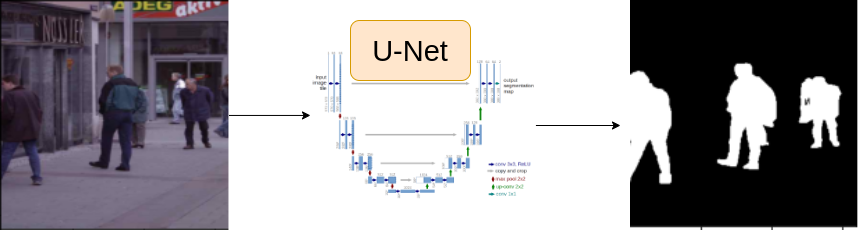

# Some Common Imports

In [3]:
import sys
sys.path.append('/content/Human-Segmentation-Dataset-master')

In [4]:
import torch
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

# Task : 2 Setup Configurations

In [5]:
CSV_FILE = '/content/Human-Segmentation-Dataset-master/train.csv'
DATA_DIR = '/content/'

DEVICE = 'cuda'

EPOCHS = 25
LR = 0.003
IMG_SIZE = 320
BATCH_SIZE = 16

ENCODER = 'timm-efficientnet-b0'
WEIGHTS = 'imagenet'

In [6]:
df = pd.read_csv(CSV_FILE)
df.head()

,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


In [7]:
row = df.loc[4]

image_path = row.images
mask_path = row.masks

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) / 255.0

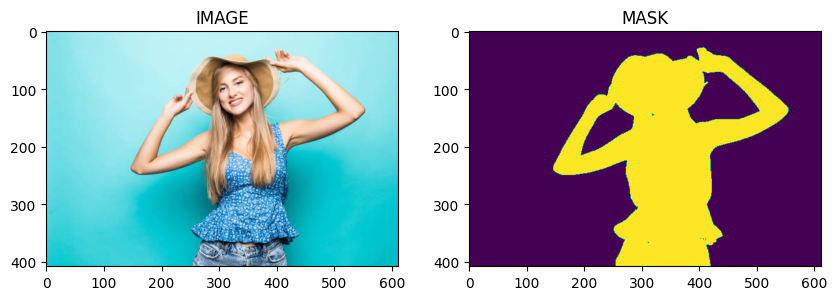

In [8]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('MASK')
ax2.imshow(mask)

In [9]:
train_df, valid_df = train_test_split(df, test_size = 0.2, random_state = 42)

# Task 3 : Augmentation Functions

albumentation documentation : https://albumentations.ai/docs/

In [10]:
import albumentations as A


In [11]:
def get_train_augs():
  return A.Compose([
      A.Resize(IMG_SIZE, IMG_SIZE),
      A.HorizontalFlip(p=0.5),
      A.VerticalFlip(p=0.5)
  ], is_check_shapes=False)

def get_valid_augs():
  return A.Compose([
      A.Resize(IMG_SIZE, IMG_SIZE)
  ], is_check_shapes=False)

# Task 4 : Create Custom Dataset

In [12]:
from torch.utils.data import Dataset

In [13]:
class SegmentationDataset(Dataset):
  def __init__(self, df, augmentations):
    self.df = df
    self.augmentations = augmentations

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):

    row = self.df.iloc[idx]

    image_path = row.images
    mask_path = row.masks

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) #(h, w, c)
    mask = np.expand_dims(mask, axis = -1)

    if self.augmentations:
      data = self.augmentations(image = image, mask = mask)
      image = data['image']
      mask = data['mask']


    # (h, w, c) -> (c, h, w)

    image = np.transpose(image, (2,0,1)).astype(np.float32)
    mask = np.transpose(mask, (2,0,1)).astype(np.float32)

    image = torch.Tensor(image) / 255.0
    mask = torch.round(torch.Tensor(mask) / 255.0)

    return image, mask



In [14]:
trainset = SegmentationDataset(train_df, get_train_augs())
validset = SegmentationDataset(valid_df, get_valid_augs())

In [15]:
print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(validset)}")

Size of Trainset : 232
Size of Validset : 58


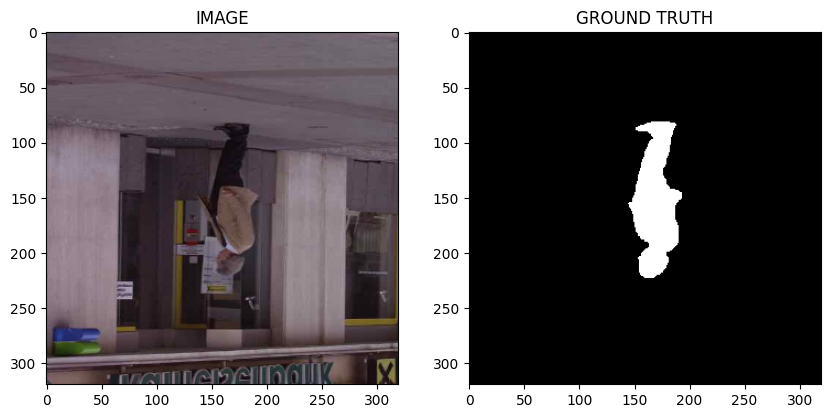

In [16]:
idx = 5

image, mask = trainset[idx]
helper.show_image(image, mask)

# Task 5 : Load dataset into batches

In [17]:
from torch.utils.data import DataLoader

In [18]:
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle = True)
validloader = DataLoader(validset, batch_size=BATCH_SIZE)


In [19]:
print(f"total no. of batches in trainloader : {len(trainloader)}")
print(f"total no. of batches in validloader : {len(validloader)}")

total no. of batches in trainloader : 15
total no. of batches in validloader : 4


In [20]:
for image, mask in trainloader:
  break

print(f"One batch image shape : {image.shape}")
print(f"One batch mask shape : {mask.shape}")

One batch image shape : torch.Size([16, 3, 320, 320])
One batch mask shape : torch.Size([16, 1, 320, 320])


# Task 6 : Create Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [21]:
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss
import torch.nn as nn
import torch.nn.functional as F

In [22]:
class SegmentationModel(nn.Module):

  def __init__(self):

    super(SegmentationModel, self).__init__()

    self.arc = smp.Unet(
        encoder_name = ENCODER,
        encoder_weights = WEIGHTS,
        in_channels = 3,
        classes = 1,
        activation = None

    )

  def forward(self, images, masks=None):
    logits = self.arc(images)


    if masks != None:
      loss1 = DiceLoss(mode='binary')(logits, masks)
      loss2 = nn.BCEWithLogitsLoss()(logits, masks)
      return logits, loss1 + loss2

    return logits

In [23]:
model = SegmentationModel()
model.to(DEVICE);

Downloading: "https://github.com/huggingface/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b0-0af12548.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_b0-0af12548.pth
100%|██████████| 20.4M/20.4M [00:02<00:00, 9.43MB/s]


# Task 7 : Create Train and Validation Function

In [24]:
def train_fn(data_loader, model, optimizer):
  model.train()
  total_loss = 0.0

  for images, masks in tqdm(data_loader):
    images = images.to(DEVICE)
    masks = masks.to(DEVICE)

    optimizer.zero_grad()
    logits, loss = model(images, masks)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  return total_loss / len(data_loader)


In [25]:
def eval_fn(data_loader, model):
  model.eval()
  total_loss = 0.0

  with torch.no_grad():
    for images, masks in tqdm(data_loader):
      images = images.to(DEVICE)
      masks = masks.to(DEVICE)


      logits, loss = model(images, masks)


      total_loss += loss.item()

  return total_loss / len(data_loader)


# Task 8 : Train Model

In [26]:
optimizer = torch.optim.Adam(model.parameters(), lr =LR)


In [27]:
best_valid_loss = np.Inf

for i in range(EPOCHS):

  train_loss = train_fn(trainloader, model, optimizer)
  valid_loss =eval_fn(validloader, model)

  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(), 'best_model.pt')
    print("SAVE-MODEL")
    best_valid_loss = valid_loss

  print(f"Epoch : {i+1} Train_loss : {train_loss} Valid_loss : {valid_loss}")


100%|██████████| 4/4 [00:01<00:00,  3.23it/s]


SAVE-MODEL
Epoch : 1 Train_loss : 0.7038866460323334 Valid_loss : 1.9775838553905487


100%|██████████| 4/4 [00:01<00:00,  3.55it/s]


SAVE-MODEL
Epoch : 2 Train_loss : 0.3735593557357788 Valid_loss : 0.40578994899988174


100%|██████████| 4/4 [00:00<00:00,  4.42it/s]


SAVE-MODEL
Epoch : 3 Train_loss : 0.2688634107510249 Valid_loss : 0.33585137128829956


100%|██████████| 4/4 [00:00<00:00,  5.25it/s]


SAVE-MODEL
Epoch : 4 Train_loss : 0.28516753812630974 Valid_loss : 0.3189716339111328


100%|██████████| 4/4 [00:00<00:00,  5.14it/s]


SAVE-MODEL
Epoch : 5 Train_loss : 0.26130842566490176 Valid_loss : 0.293281152844429


100%|██████████| 4/4 [00:00<00:00,  5.14it/s]


SAVE-MODEL
Epoch : 6 Train_loss : 0.19869800607363383 Valid_loss : 0.20333077758550644


100%|██████████| 4/4 [00:00<00:00,  5.16it/s]


Epoch : 7 Train_loss : 0.198030553261439 Valid_loss : 0.23569152131676674


100%|██████████| 4/4 [00:01<00:00,  3.67it/s]


SAVE-MODEL
Epoch : 8 Train_loss : 0.15664294759432476 Valid_loss : 0.18622246757149696


100%|██████████| 4/4 [00:00<00:00,  5.21it/s]


Epoch : 9 Train_loss : 0.17260547081629435 Valid_loss : 0.1897696703672409


100%|██████████| 4/4 [00:00<00:00,  4.95it/s]


Epoch : 10 Train_loss : 0.16524416108926138 Valid_loss : 0.2461695373058319


100%|██████████| 4/4 [00:00<00:00,  5.11it/s]


Epoch : 11 Train_loss : 0.17875459641218186 Valid_loss : 0.24203833937644958


100%|██████████| 4/4 [00:00<00:00,  5.20it/s]


SAVE-MODEL
Epoch : 12 Train_loss : 0.1742899775505066 Valid_loss : 0.17406464368104935


100%|██████████| 4/4 [00:00<00:00,  5.19it/s]


Epoch : 13 Train_loss : 0.1587536722421646 Valid_loss : 0.2123421374708414


100%|██████████| 4/4 [00:00<00:00,  5.19it/s]


Epoch : 14 Train_loss : 0.12543579041957856 Valid_loss : 0.19473636522889137


100%|██████████| 4/4 [00:00<00:00,  5.26it/s]


Epoch : 15 Train_loss : 0.11973856240510941 Valid_loss : 0.21211125701665878


100%|██████████| 4/4 [00:00<00:00,  4.27it/s]


Epoch : 16 Train_loss : 0.15176642884810765 Valid_loss : 0.18097204715013504


100%|██████████| 4/4 [00:00<00:00,  5.23it/s]


Epoch : 17 Train_loss : 0.149181500573953 Valid_loss : 0.203694187104702


100%|██████████| 4/4 [00:00<00:00,  5.17it/s]


Epoch : 18 Train_loss : 0.1344718525807063 Valid_loss : 0.20592228323221207


100%|██████████| 4/4 [00:00<00:00,  4.50it/s]


Epoch : 19 Train_loss : 0.12240708023309707 Valid_loss : 0.2681324575096369


100%|██████████| 4/4 [00:00<00:00,  5.09it/s]


SAVE-MODEL
Epoch : 20 Train_loss : 0.11171623170375825 Valid_loss : 0.17147508636116982


100%|██████████| 4/4 [00:00<00:00,  5.16it/s]


Epoch : 21 Train_loss : 0.128688849012057 Valid_loss : 0.19068487733602524


100%|██████████| 4/4 [00:00<00:00,  5.21it/s]


Epoch : 22 Train_loss : 0.10660077631473541 Valid_loss : 0.21461257711052895


100%|██████████| 4/4 [00:00<00:00,  5.15it/s]


Epoch : 23 Train_loss : 0.10322971294323603 Valid_loss : 0.20233368128538132


100%|██████████| 4/4 [00:01<00:00,  3.83it/s]


Epoch : 24 Train_loss : 0.10095556378364563 Valid_loss : 0.17488598078489304


100%|██████████| 4/4 [00:00<00:00,  5.20it/s]

Epoch : 25 Train_loss : 0.14627948900063834 Valid_loss : 0.21474561467766762


# Task 9 : Inference

In [28]:
idx = 20

model.load_state_dict(torch.load('/content/best_model.pt'))

image, mask = validset[idx]

logits_mask = model(image.to(DEVICE).unsqueeze(0)) #(C, H, W) -> (1, C, H, W)
pred_mask = torch.sigmoid(logits_mask)
pred_mask = (pred_mask > 0.5)*1.0

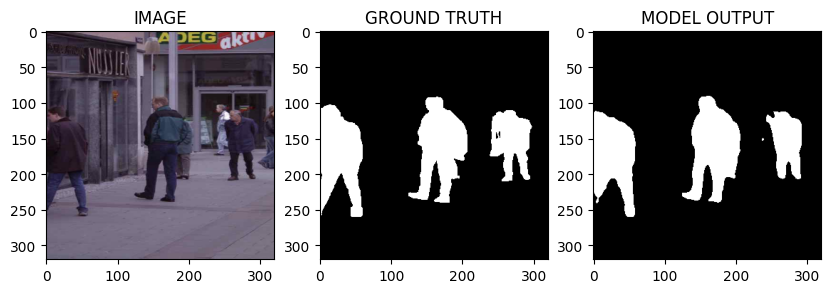

In [29]:
helper.show_image(image, mask, pred_mask.detach().cpu().squeeze(0))